# **U-Net Implementation**
| Name         | Surname    | ID        |
|--------------|------------|-----------|
| ABOUELAZM    | Youssef    | 10960436  |
| BINGLING     | Wu         | 11105141  |
| GARCIA       | Adrian     | 10975956  |
| OUALI        | Ernest     | 10984484  |

This notebook implements an U-Net architecture to adress Music Source Separation

## **Import Audio Data**

In [1]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import librosa
import random
import gc
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
# check if tensorflow is using GPU
print(tf.config.list_physical_devices('GPU'))

import museval

from tqdm import tqdm

import matplotlib.pyplot as plt

import IPython.display as ipd


tf.keras.backend.clear_session()
gc.collect()

batch_size = 2

TRAIN = True
TEST = True
# don't change these except if you will process new data
LOAD_NEW_DATA = True
NFFT = 1024
HOP_LENGTH = 512
SR = 16000
DURATION = 5 # seconds
MAIN_DIR = os.path.join("Datasets", "combined_data")

target = "other"
SAVED_DATA_PATH = f"my_data_{target}.npz"
models_to_train = [target] 




2025-06-10 20:39:56.547693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]


In [2]:
# Load Training Tracks
def load_data(data_dir):
    """
    Load audio data from the specified directory.

    Args:
        data_dir (str): Path to the directory containing audio files.

    Returns:
        list: A list of tuples (audio, sample_rate) for each audio file.
    """
    audio_data = []
    print(f"Loading audio files from {data_dir}...")
    for filename in tqdm(os.listdir(data_dir), desc="Loading audio files"):
        if filename.endswith(".wav"):
            file_path = os.path.join(data_dir, filename)
            audio, sample_rate = librosa.load(file_path, sr = SR, mono=True)
            audio_data.append((audio))
    return audio_data

# adjust the length of the audio files to be the same
def adjust_length(audio_list, target_length):
    """
    Adjust the length of audio files to a target length by padding or truncating.
    Removes sample rate information as it is not needed for the model.
    Args:
        audio_list (list): List of audio data.
        target_length (int): Target length for each audio file.

    Returns:
        list: List of adjusted audio files.
    """
    adjusted_audio = []
    for audio in audio_list:
        if len(audio) < target_length:
            # Pad with zeros if the audio is shorter than the target length
            padded_audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            adjusted_audio.append((padded_audio))
        else:
            # Truncate if the audio is longer than the target length
            truncated_audio = audio[:target_length]
            adjusted_audio.append((truncated_audio))
    return adjusted_audio



In [3]:
if LOAD_NEW_DATA:
    print("Loading new data...")
    
    X_train_audio = load_data(os.path.join(MAIN_DIR, "train", "mix"))
    Y_train_audio = load_data(os.path.join(MAIN_DIR, "train", target))
   
    X_valid_audio = load_data(os.path.join(MAIN_DIR, "valid", "mix"))
    Y_valid_audio = load_data(os.path.join(MAIN_DIR, "valid", target))
  

    X_test_audio = load_data(os.path.join(MAIN_DIR, "test", "mix"))
    Y_test_audio = load_data(os.path.join(MAIN_DIR, "test", target))
    

Loading new data...
Loading audio files from Datasets\combined_data\train\mix...


Loading audio files: 100%|██████████| 976/976 [00:21<00:00, 45.25it/s]


Loading audio files from Datasets\combined_data\train\other...


Loading audio files: 100%|██████████| 976/976 [00:16<00:00, 58.70it/s]


Loading audio files from Datasets\combined_data\valid\mix...


Loading audio files: 100%|██████████| 140/140 [00:02<00:00, 62.25it/s]


Loading audio files from Datasets\combined_data\valid\other...


Loading audio files: 100%|██████████| 140/140 [00:02<00:00, 69.90it/s]


Loading audio files from Datasets\combined_data\test\mix...


Loading audio files: 100%|██████████| 500/500 [00:07<00:00, 67.62it/s]


Loading audio files from Datasets\combined_data\test\other...


Loading audio files: 100%|██████████| 500/500 [00:07<00:00, 65.93it/s]


In [4]:
    
if LOAD_NEW_DATA:
    # target length in samples
    target_length = int(DURATION * SR)   
    
    # Adjust the length of the audio files
    X_train_audio = adjust_length(X_train_audio, target_length)
    Y_train_audio = adjust_length(Y_train_audio, target_length)

    X_valid_audio = adjust_length(X_valid_audio, target_length)
    Y_valid_audio = adjust_length(Y_valid_audio, target_length)
    
    X_test_audio = adjust_length(X_test_audio, target_length)
    Y_test_audio = adjust_length(Y_test_audio, target_length)
   

    #convert to numpy arrays
    X_train_audio = np.array([audio for audio in X_train_audio])
    Y_train_audio = np.array([audio for audio in Y_train_audio])
    
    X_valid_audio = np.array([audio for audio in X_valid_audio])
    Y_valid_audio = np.array([audio for audio in Y_valid_audio])
   
    X_test_audio = np.array([audio for audio in X_test_audio])
    Y_test_audio = np.array([audio for audio in Y_test_audio])
    
    

    print("Audio loaded successfully.")

Audio loaded successfully.


In [5]:


def remove_zero_samples(X, Y):
    # Use a list comprehension to filter out pairs where X is all zeros
    filtered_X = []
    filtered_Y = []
    
    for x, y in zip(X, Y):
        if not (np.all(y == 0) or np.all(x == 0)) :  # Check if X is not all zeros
            filtered_X.append(x)
            filtered_Y.append(y)
    
    return np.array(filtered_X), np.array(filtered_Y)


if LOAD_NEW_DATA:
    # Remove all-zero samples for training data
    X_train_audio, Y_train_audio = remove_zero_samples(X_train_audio, Y_train_audio)

    # Remove all-zero samples for validation data
    X_valid_audio, Y_valid_audio = remove_zero_samples(X_valid_audio, Y_valid_audio)

    # Remove all-zero samples for test data
    X_test_audio, Y_test_audio = remove_zero_samples(X_test_audio, Y_test_audio)

    # Print shapes after removing zero samples
    print("Shapes after filtering:")
    print("X_train_audio shape:", X_train_audio.shape)
    print("Y_train_audio shape:", Y_train_audio.shape)
    print("X_valid_audio shape:", X_valid_audio.shape)
    print("Y_valid_audio shape:", Y_valid_audio.shape)
    print("X_test_audio shape:", X_test_audio.shape)
    print("Y_test_audio shape:", Y_test_audio.shape)


Shapes after filtering:
X_train_audio shape: (940, 80000)
Y_train_audio shape: (940, 80000)
X_valid_audio shape: (134, 80000)
Y_valid_audio shape: (134, 80000)
X_test_audio shape: (476, 80000)
Y_test_audio shape: (476, 80000)


## **Perform STFT**

In [6]:
# Perform STFT on the audio data
def compute_stft(audio_data, n_fft=NFFT, hop_length=HOP_LENGTH):
    """
    Compute the Short-Time Fourier Transform (STFT) of the audio data.

    Args:
        audio_data (list): List of tuples (audio, sample_rate).
        n_fft (int): Number of FFT components.
        hop_length (int): Number of samples between successive frames.

    Returns:
        list: List of STFT results for each audio file.
    """
    stft_data = []
    print("Computing STFT for audio files...")
    for audio in tqdm(audio_data, desc="Computing STFT"):
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        stft_data.append(stft)
    return stft_data

In [7]:

if LOAD_NEW_DATA:
    print("Computing STFT for training data...")
    X_train_stft = compute_stft(X_train_audio)
    Y_train_stft = compute_stft(Y_train_audio)


    print("Computing STFT for validation data...")
    X_valid_stft = compute_stft(X_valid_audio)
    Y_valid_stft = compute_stft(Y_valid_audio)
    

    print("Computing STFT for test data...")
    X_test_stft = compute_stft(X_test_audio)
    Y_test_stft = compute_stft(Y_test_audio)
    

    # Convert STFT data to numpy arrays
    X_train_stft_phase = np.array([np.angle(stft) for stft in X_train_stft]) 
    X_train_stft = np.array([np.abs(stft) for stft in X_train_stft])
    Y_train_stft = np.array([np.abs(stft) for stft in Y_train_stft])
    

    X_valid_stft_phase = np.array([np.angle(stft) for stft in X_valid_stft])
    X_valid_stft = np.array([np.abs(stft) for stft in X_valid_stft])
    Y_valid_stft = np.array([np.abs(stft) for stft in Y_valid_stft])
    

    X_test_stft_phase = np.array([np.angle(stft) for stft in X_test_stft]) 
    X_test_stft = np.array([np.abs(stft) for stft in X_test_stft])
    Y_test_stft = np.array([np.abs(stft) for stft in Y_test_stft])


    
    # save the data to disk, to clear memory
    np.savez(SAVED_DATA_PATH,X_train_stft = X_train_stft, Y_train_stft = Y_train_stft,
        X_train_stft_phase = X_train_stft_phase,X_valid_stft = X_valid_stft, Y_valid_stft = Y_valid_stft,
        X_valid_stft_phase = X_valid_stft_phase,X_test_stft = X_test_stft, Y_test_stft = Y_test_stft,
        X_test_stft_phase = X_test_stft_phase,X_train_audio = X_train_audio,Y_train_audio = Y_train_audio,           
        X_valid_audio = X_valid_audio,Y_valid_audio = Y_valid_audio,
        X_test_audio = X_test_audio,Y_test_audio = Y_test_audio)
    
    # clear memory
    del X_train_audio, Y_train_audio
    del X_valid_audio, Y_valid_audio
    del X_test_audio, Y_test_audio
    del X_train_stft, Y_train_stft
    del X_valid_stft, Y_valid_stft
    del X_test_stft, Y_test_stft
    del X_train_stft_phase, X_valid_stft_phase, X_test_stft_phase


Computing STFT for training data...
Computing STFT for audio files...


Computing STFT: 100%|██████████| 940/940 [00:02<00:00, 469.23it/s]


Computing STFT for audio files...


Computing STFT: 100%|██████████| 940/940 [00:01<00:00, 481.71it/s]


Computing STFT for validation data...
Computing STFT for audio files...


Computing STFT: 100%|██████████| 134/134 [00:00<00:00, 518.83it/s]


Computing STFT for audio files...


Computing STFT: 100%|██████████| 134/134 [00:00<00:00, 457.25it/s]


Computing STFT for test data...
Computing STFT for audio files...


Computing STFT: 100%|██████████| 476/476 [00:01<00:00, 455.41it/s]


Computing STFT for audio files...


Computing STFT: 100%|██████████| 476/476 [00:00<00:00, 493.85it/s]


In [8]:
# function to play and plot STFT of a mix and target by index
def play_and_plot(X_audio,Y_audio,X_stft,Y_stft,target =target):
    """
    Play and plot the STFT of a mix and target track by index.

    Args:
        index (int): Index of the track to play and plot.
    """
    X_stft = np.abs(X_stft)
    Y_stft = np.abs(Y_stft)

    # Play audio
    ipd.display(ipd.Audio(X_audio, rate=SR))
    ipd.display(ipd.Audio(Y_audio, rate=SR))

    # subplot for mix and target STFT
    # use freqs and time_frames for x and y axes
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(X_stft, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f'STFT Magnitude for mix Track')
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_stft, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f'STFT Magnitude for {target} Track')
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')
    plt.show()



In [9]:
# data = np.load(SAVED_DATA_PATH)
# X_train_stft = data['X_train_stft']
# Y_train_stft = data['Y_train_stft']
# X_train_audio = data['X_train_audio']
# Y_train_audio = data['Y_train_audio']

# del data


# i = random.randint(0, len(X_train_audio) - 1)
# print(f"plotting track index: {i}")
# play_and_plot(X_train_audio[i],Y_train_audio[i],X_train_stft[i],Y_train_stft[i])


## **Define and Train Models**

**Define Model**

In [3]:

def build_unet_model(input_shape):
    reg = regularizers.l2(1e-5)

    inputs = layers.Input(shape=input_shape)

    # Padding to make dimensions divisible by 8
    pad_height = (8 - input_shape[0] % 8) % 8
    pad_width = (8 - input_shape[1] % 8) % 8
    x = layers.ZeroPadding2D(((0, pad_height), (0, pad_width)))(inputs)

    # Encoder
    c1 = layers.Conv2D(8, (3, 3), padding='same', kernel_regularizer=reg)(x)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.ReLU()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=reg)(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.ReLU()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg)(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.ReLU()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bn = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=reg)(p3)
    bn = layers.BatchNormalization()(bn)
    bn = layers.ReLU()(bn)
    bn = layers.Dropout(0.3)(bn)

    # Decoder
    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=reg)(bn)
    concat1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg)(concat1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.ReLU()(c4)
    c4 = layers.Dropout(0.1)(c4)

    u2 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=reg)(c4)
    concat2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=reg)(concat2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.ReLU()(c5)
    c5 = layers.Dropout(0.1)(c5)

    u3 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=reg)(c5)
    concat3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(8, (3, 3), padding='same', kernel_regularizer=reg)(concat3)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.ReLU()(c6)
    c6 = layers.Dropout(0.1)(c6)

    # Output layer: linear for continuous magnitude prediction
    outputs = layers.Conv2D(1, (1, 1), activation='linear')(c6)

    # Crop to original shape
    outputs = layers.Cropping2D(((0, pad_height), (0, pad_width)))(outputs)

    model = models.Model(inputs, outputs)
    return model


In [ ]:

# def tfc_block(x, filters, reg):
#     # Temporal path
#     t = layers.Conv2D(filters, (3, 1), padding='same', kernel_regularizer=reg)(x)
#     t = layers.BatchNormalization()(t)
#     t = layers.Activation('gelu')(t)

#     # Frequency path
#     f = layers.Conv2D(filters, (1, 3), padding='same', kernel_regularizer=reg)(x)
#     f = layers.BatchNormalization()(f)
#     f = layers.Activation('gelu')(f)

#     # Combine
#     return layers.Add()([t, f])

# def build_unet_with_tfc(input_shape):
#     reg = regularizers.l2(1e-5)

#     inputs = layers.Input(shape=input_shape)

#     # Padding to make divisible by 8
#     pad_height = (8 - input_shape[0] % 8) % 8
#     pad_width = (8 - input_shape[1] % 8) % 8
#     x = layers.ZeroPadding2D(((0, pad_height), (0, pad_width)))(inputs)
#     mix_input = x  # For output skip connection

#     # Encoder with TFC
#     c1 = layers.SeparableConv2D(8, (3, 3), padding='same', kernel_regularizer=reg)(x)
#     c1 = tfc_block(c1, 8, reg)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=reg)(p1)
#     c2 = tfc_block(c2, 16, reg)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     c3 = layers.SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=reg)(p2)
#     c3 = tfc_block(c3, 32, reg)
#     p3 = layers.MaxPooling2D((2, 2))(c3)

#     # Bottleneck
#     bn = layers.SeparableConv2D(64, (3, 3), padding='same', kernel_regularizer=reg)(p3)
#     bn = layers.BatchNormalization()(bn)
#     bn = layers.Activation('gelu')(bn)
#     bn = layers.Dropout(0.3)(bn)

#     # Decoder with TFC
#     u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(bn)
#     concat1 = layers.Concatenate()([u1, c3])
#     c4 = tfc_block(concat1, 32, reg)

#     u2 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
#     concat2 = layers.Concatenate()([u2, c2])
#     c5 = tfc_block(concat2, 16, reg)

#     u3 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c5)
#     concat3 = layers.Concatenate()([u3, c1])
#     c6 = tfc_block(concat3, 8, reg)

#     # Output head
#     out_main = layers.SeparableConv2D(1, (1, 1), activation='linear')(c6)
#     out_combined = layers.Concatenate()([out_main, mix_input])
#     out_final = layers.SeparableConv2D(1, (1, 1), activation='linear')(out_combined)

#     # Crop to original size
#     out_final = layers.Cropping2D(((0, pad_height), (0, pad_width)))(out_final)

#     model = models.Model(inputs, out_final)
#     return model


In [12]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau

def create_callbacks(log_name, model_name, restore_Weights=False):
    callbacks = []

    tensorboard_callback = TensorBoard(log_dir=os.path.join("logs", log_name), histogram_freq=1)
    callbacks.append(tensorboard_callback)

    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join("checkpoints", model_name),
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    callbacks.append(checkpoint_callback)

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=restore_Weights
    )
    callbacks.append(early_stopping_callback)

    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.5,
        min_lr=1e-6
    )
    callbacks.append(reduce_lr_callback)

    return callbacks


In [13]:
def compile_and_train_model(model, X_train, Y_train, X_valid, Y_valid,
                            learning_rate=0.01, batch_size=batch_size,
                            epochs=1000, callbacks=None, loss='mean_squared_error'):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=['mae']
    )

    history = model.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_valid, Y_valid),
        callbacks=callbacks,
        verbose=1
    )
    return history


In [14]:
def plot_training_history(log_file, history):
    """                         
    Plot the training and validation loss and accuracy from the training history.
    Args:
        log_file (str): Path to the log file.
        history (tf.keras.callbacks.History): Training history object.
    """
    # Extract loss and accuracy from the history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_mae = history.history.get('mae', [])
    val_mae = history.history.get('val_mae', [])
    epochs = range(1, len(train_loss) + 1)
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_mae, 'b', label='Training MAE')
    plt.plot(epochs, val_mae, 'r', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join("logs",f"{log_file}.png"))
    plt.show()


    best_val_mae = min(val_mae) if val_mae else None
    best_epoch_mae = val_mae.index(best_val_mae) + 1 if best_val_mae is not None else None
    best_train_mae = min(train_mae) if train_mae else None
    min_val_loss = min(val_loss) if val_loss else None
    best_epoch_loss = val_loss.index(min_val_loss) + 1 if min_val_loss is not None else None

    return best_val_mae, best_epoch_mae, best_train_mae, min_val_loss, best_epoch_loss

In [15]:
if TRAIN:
    
    print(f"Loading {target} training data from disk...")
    data = np.load(SAVED_DATA_PATH)
    X_train_stft = data['X_train_stft']
    X_valid_stft = data['X_valid_stft']
    Y_train_stft = data['Y_train_stft']
    Y_valid_stft = data['Y_valid_stft']
    del data
    # use moveaxis to swap axes 1 and 2 for STFT data
    X_train= np.moveaxis(X_train_stft, 1, 2)
    X_valid= np.moveaxis(X_valid_stft, 1, 2)

    Y_train= np.moveaxis(Y_train_stft, 1, 2)
    Y_valid= np.moveaxis(Y_valid_stft, 1, 2)

    del X_train_stft, Y_train_stft, X_valid_stft, Y_valid_stft
    print(f'Input shape: {X_train.shape}')
    # Define input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2], 1)  # (frequency_bins, time_frames, channels)
    model = build_unet_model(input_shape)
    # model = build_unet_with_tfc(input_shape)
    # Printing the summary
    model.summary()  



Loading other training data from disk...
Input shape: (940, 157, 513)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 157, 513, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 160, 520, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 520, 8)  80          ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (Ba

In [16]:
if TRAIN:
    callbacks = create_callbacks(log_name=f"unet_basic_{target}", model_name=f"unet_basic_{target}.h5", restore_Weights=True)
    # Train the model
    history = compile_and_train_model(model, X_train, Y_train, X_valid, Y_valid, callbacks=callbacks)
    model.save_weights(f"checkpoints/unet_basic_{target}_weights.h5")
    del X_train, Y_train, X_valid, Y_valid, model

Epoch 1/1000
470/470 [==============================] - 25s 25ms/step - loss: 3.0404 - mae: 0.4989 - val_loss: 0.6271 - val_mae: 0.2965 - lr: 0.0100
Epoch 2/1000
470/470 [==============================] - 10s 22ms/step - loss: 2.8858 - mae: 0.4846 - val_loss: 0.5993 - val_mae: 0.2541 - lr: 0.0100
Epoch 3/1000
470/470 [==============================] - 10s 21ms/step - loss: 2.8347 - mae: 0.4835 - val_loss: 0.8009 - val_mae: 0.3984 - lr: 0.0100
Epoch 4/1000
470/470 [==============================] - 10s 21ms/step - loss: 2.7927 - mae: 0.4801 - val_loss: 0.8085 - val_mae: 0.4048 - lr: 0.0100
Epoch 5/1000
470/470 [==============================] - 10s 22ms/step - loss: 2.8046 - mae: 0.4880 - val_loss: 0.6080 - val_mae: 0.2483 - lr: 0.0100
Epoch 6/1000
470/470 [==============================] - 11s 22ms/step - loss: 2.7657 - mae: 0.4769 - val_loss: 0.7059 - val_mae: 0.3524 - lr: 0.0100
Epoch 7/1000
470/470 [==============================] - 11s 23ms/step - loss: 2.7355 - mae: 0.4809 - val_l

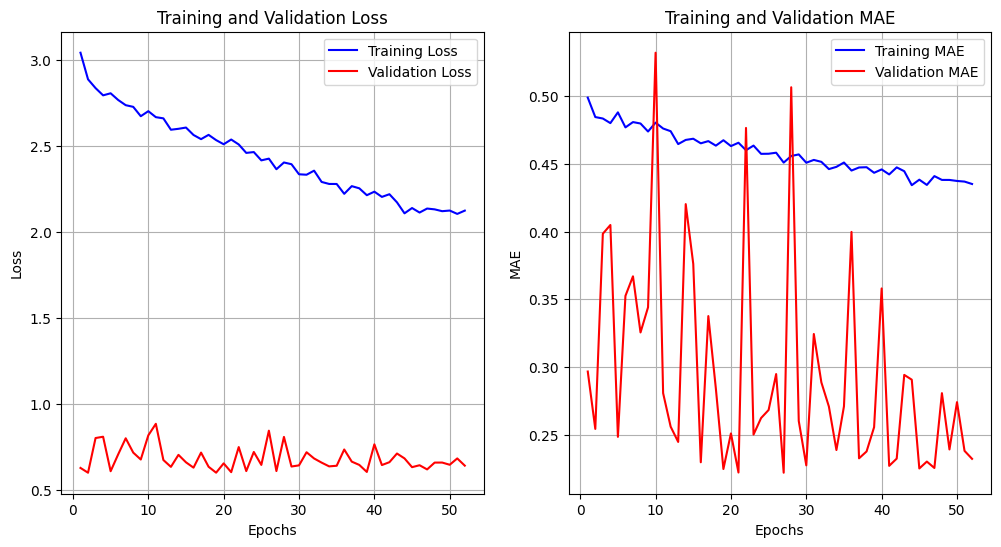

Best Validation MAE: 0.2217750996351242 at epoch 27


In [17]:
if TRAIN:
    results = plot_training_history(log_file = f"unet_basic_{target}",history=history)
    print(f"Best Validation MAE: {results[0]} at epoch {results[1]}")

In [18]:
# load the model weights if needed
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae'])
# model.load_weights("checkpoints/unet_weights.h5")

In [19]:

# test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=1)

In [20]:
if TEST:
        
    data = np.load(SAVED_DATA_PATH)
    X_test_stft = data['X_test_stft']
    X_test_stft_phase = data['X_test_stft_phase']
    Y_test_stft = data['Y_test_stft']
    Y_test_audio = data['Y_test_audio']
    X_test_audio = data['X_test_audio']

In [21]:
if TEST:
    model = build_unet_model((X_test_stft.shape[2], X_test_stft.shape[1], 1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae'])
    model.load_weights(f"checkpoints/unet_basic_{target}_weights.h5")


In [22]:
#del data, X_test_stft, Y_test_stft, X_test_stft_phase, X_test_audio, Y_test_audio
#del model_vocals

Testing track index: 432
1/1 [==============================] - 1s 942ms/step
Original mix audio:


Original other audio:


Predicted audio:


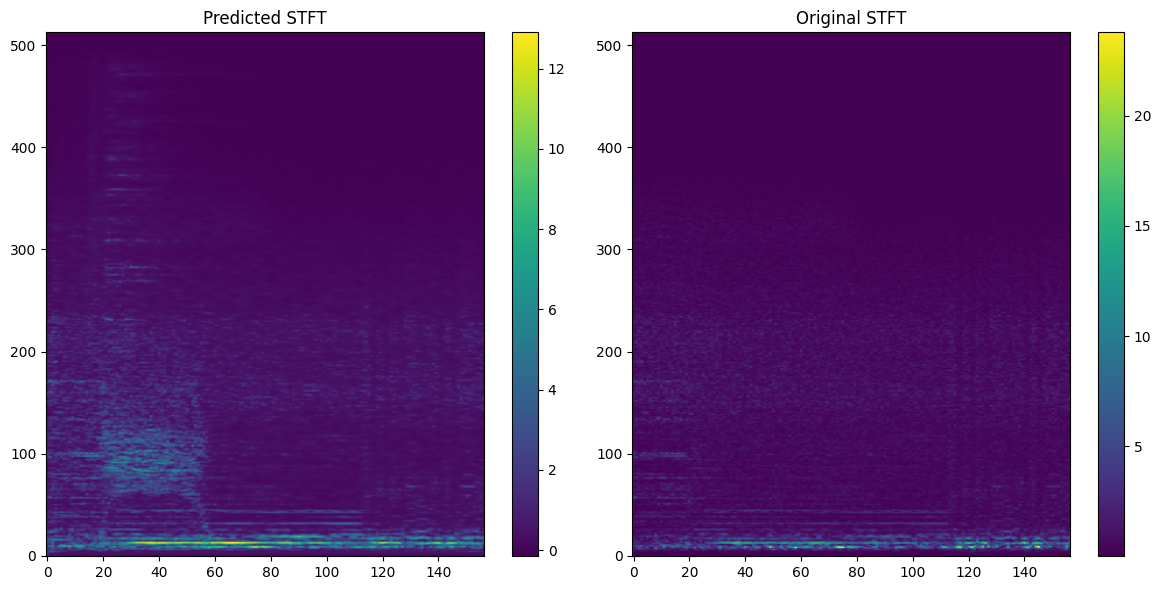

In [23]:

def test_track(model,stft_mag, stft_phase):
    """
    Test the model on a single track and return the predicted audio.

    Args:
        stft_mag (np.ndarray): STFT magnitude of the input audio.
        stft_phase (np.ndarray): STFT phase of the input audio.

    Returns:
        np.ndarray: Predicted audio signal.
    """
    stft_mag = np.moveaxis(stft_mag, 0,1)
    # Reshape the input to match the model's expected input shape
    stft_mag = np.expand_dims(stft_mag, axis=0)  # Add batch dimension
    stft_mag = np.expand_dims(stft_mag, axis=-1)  # Add channel dimension

    # Predict the STFT magnitude
    predicted_stft_mag = model.predict(stft_mag)

    # Reshape the predicted STFT to match the original shape
    predicted_stft_mag = np.squeeze(predicted_stft_mag)  # Remove batch dimension
    predicted_stft_mag = np.moveaxis(predicted_stft_mag,0,1)

    # Reconstruct the audio from the predicted STFT
    predicted_audio = librosa.istft(predicted_stft_mag * np.exp(1j * stft_phase), hop_length=HOP_LENGTH)
    # predicted_audio = librosa.griffinlim(predicted_stft_mag, hop_length=HOP_LENGTH, n_iter=32)

    return predicted_audio,predicted_stft_mag


if TEST:

    i = random.randint(0, len(X_test_stft) - 1)
    print(f"Testing track index: {i}")
    predicted_audio, predicted_stft = test_track(model,X_test_stft[i], X_test_stft_phase[i])
    original_mix = X_test_audio[i]
    original_target = Y_test_audio[i]
    original_target_stft = Y_test_stft[i]

    # play the original audio
    print("Original mix audio:")
    ipd.display(ipd.Audio(original_mix, rate=SR))
    # play the original target audio
    print(f"Original {target} audio:")
    ipd.display(ipd.Audio(original_target, rate=SR))
    # Play the predicted audio
    print("Predicted audio:")
    ipd.display(ipd.Audio(predicted_audio, rate=SR))


    # Plot the predicted and original drums STFT


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Predicted STFT")
    plt.imshow(predicted_stft, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("Original STFT")
    plt.imshow(original_target_stft, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join("images",f"sample_result_{target}.png"))
    plt.show()


In [24]:

def test_full_set(model, X_test_stft, X_test_stft_phase, Y_test_audio, hop_length=HOP_LENGTH):
    predicted_audios = []
    valid_targets = []

    for i in tqdm(range(len(X_test_stft)), desc="Predicting test set"):
        # Prepare input
        stft_mag = np.moveaxis(X_test_stft[i], 0, 1)
        stft_mag = np.expand_dims(stft_mag, axis=(0, -1))

        # Predict
        predicted_stft_mag = model.predict(stft_mag, verbose=0)
        predicted_stft_mag = np.squeeze(predicted_stft_mag)
        predicted_stft_mag = np.moveaxis(predicted_stft_mag, 0, 1)

        # Reconstruct audio
        predicted_audio = librosa.istft(predicted_stft_mag * np.exp(1j * X_test_stft_phase[i]), hop_length=hop_length)

        # Ensure the audio is same length as ground truth
        target_audio = Y_test_audio[i]
        min_len = min(len(predicted_audio), len(target_audio))
        predicted_audio = predicted_audio[:min_len]
        target_audio = target_audio[:min_len]

        predicted_audios.append(predicted_audio[np.newaxis, :])  # shape (1, n_samples)
        valid_targets.append(target_audio[np.newaxis, :])        # shape (1, n_samples)

    # Stack for evaluation
    predicted_stack = np.stack(predicted_audios)  # shape (n, 1, n_samples)
    target_stack = np.stack(valid_targets)

    return predicted_stack, target_stack

if TEST:
# Reconstruct
    predicted_stack, target_stack = test_full_set(model, X_test_stft, X_test_stft_phase, Y_test_audio, hop_length=HOP_LENGTH)

Predicting test set: 100%|██████████| 476/476 [00:39<00:00, 11.99it/s]


In [25]:
def compute_sdr(predicted_stack, target_stack):
    sdr_scores = []

    for i in range(len(predicted_stack)):
        ref = target_stack[i]
        est = predicted_stack[i]

        # Skip silent reference
        if np.all(ref == 0):
            print(f"Clip {i}: skipped (reference is silent)")
            continue

        # Compute SDR
        _, _, _, sdr = museval.evaluate(ref, est)
        
        # Check if SDR is nan and print a message if it is
        if np.isnan(sdr):
            print(f"Clip {i}: SDR is nan, skipping...")
            continue
        
        sdr_scores.append(sdr)

    return np.array(sdr_scores)

if TEST:
    # evaluate
    sdr_scores = compute_sdr(predicted_stack, target_stack)


    output_dir = "results"
    output_file = os.path.join(output_dir, f"{target}_sdr.txt")

    # Create the directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)


    # Open the file in write mode and save the results
    with open(output_file, "w") as f:
        if len(sdr_scores) > 0:
            mean_sdr = np.mean(sdr_scores)
            median_sdr = np.median(sdr_scores)
            min_sdr = np.min(sdr_scores)
            max_sdr = np.max(sdr_scores)

            f.write("SDR Results:\n")
            f.write(f"Mean SDR: {mean_sdr:.4f}\n")
            f.write(f"Median SDR: {median_sdr:.4f}\n")
            f.write(f"Min SDR: {min_sdr:.4f}\n")
            f.write(f"Max SDR: {max_sdr:.4f}\n")

            print("SDR Results:")
            print(f"Mean SDR: {mean_sdr}")
            print(f"Median SDR: {median_sdr}")
            print(f"Min SDR: {min_sdr}")
            print(f"Max SDR: {max_sdr}")
        else:
            f.write("No valid SDR scores to compute.\n")
            print("No valid SDR scores to compute.")

Clip 40: SDR is nan, skipping...
Clip 114: SDR is nan, skipping...
Clip 135: SDR is nan, skipping...
Clip 361: SDR is nan, skipping...
Clip 419: SDR is nan, skipping...
SDR Results:
Mean SDR: -1.5745142501437266
Median SDR: -0.7003424267966436
Min SDR: -71.96300340202282
Max SDR: 14.725179012413015
